In [148]:
import glob
import yaml
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
plt.rcParams.update({
    "text.usetex": True,
})
plt.style.use("default")

In [130]:
def group_yaml_files(yaml_path):
    exp_dihadron_files = []
    exp_dis_files = []
    mc_dihadron_files = []
    mc_dis_files = []
    
    for file_path in glob.glob(yaml_path + '/*_exp_dihadron.yaml'):
        exp_dihadron_files.append(file_path)
    for file_path in glob.glob(yaml_path + '/*_exp_dis.yaml'):
        exp_dis_files.append(file_path)
    for file_path in glob.glob(yaml_path + '/*_mc_dihadron.yaml'):
        mc_dihadron_files.append(file_path)
    for file_path in glob.glob(yaml_path + '/*_mc_dis.yaml'):
        mc_dis_files.append(file_path)
    
    return [exp_dihadron_files, exp_dis_files, mc_dihadron_files, mc_dis_files]

In [140]:
def load_yaml_files(filenames):
    yaml_files = []

    for filename in filenames:
        with open(filename, 'r') as file:
            yaml_files.append(yaml.safe_load(file))

    return yaml_files

def add_counts(yaml1, yaml2):
    for key in yaml1:
        if key not in yaml2:
            continue
        if isinstance(yaml1[key], dict) and isinstance(yaml2[key], dict):
            add_counts(yaml1[key], yaml2[key])
        elif key == "Counts":
            yaml1[key] += yaml2[key]
            yaml1["Error"] = np.sqrt(yaml1[key])

def sum_counts(yaml_files):
    result = yaml_files[0]

    for yaml_file in yaml_files[1:]:
        add_counts(result, yaml_file)
    
    return result

def divide_counts(yaml1, yaml2,level=0):
    if(level==0):
        div_yaml=copy.deepcopy(yaml1)
    else:
        div_yaml=yaml1
    for key in div_yaml:
        if key not in yaml2:
            continue
        if isinstance(div_yaml[key], dict) and isinstance(yaml2[key], dict):
            divide_counts(div_yaml[key], yaml2[key],level=1)
        elif key == "Counts":
            if(yaml2[key]==0 or div_yaml[key]==0):
                div_yaml[key]=0
                div_yaml["Error"]=0
            else:
                # Calculate relative errors for div_yaml[key] and yaml2[key]
                div_yaml_rel_error = np.sqrt(div_yaml[key]) / div_yaml[key]
                yaml2_rel_error = np.sqrt(yaml2[key]) / yaml2[key]
                # Propagate the error
                total_rel_error = np.sqrt(div_yaml_rel_error**2 + yaml2_rel_error**2)

                # Calculate the result and its error
                result = div_yaml[key] / yaml2[key]
                result_error = total_rel_error * result

                # Update div_yaml["Error"]
                div_yaml["Error"] = result_error
                div_yaml[key]= result
                
    return div_yaml
            
def get_yaml_total(file_list):
    yaml_list=load_yaml_files(file_list)
    print(len(yaml_list))
    yaml_total=sum_counts(yaml_list)
    return yaml_total

def run(pion_pair):
    project_dir = "/work/clas12/users/gmat/clas12/clas12_dihadrons/projects"
    project_name = "ana_v1"
    yaml_path = f"{project_dir}/{project_name}/volatile/multiplicities/yaml/{pion_pair}"
    file_lists=group_yaml_files(yaml_path)

    exp_dihadron_file_list=file_lists[0]
    exp_dis_file_list=file_lists[1]
    mc_dihadron_file_list=file_lists[2]
    mc_dis_file_list=file_lists[3]

    exp_2h_yaml = get_yaml_total(exp_dihadron_file_list)
    exp_dis_yaml = get_yaml_total(exp_dis_file_list)
    mc_2h_yaml = get_yaml_total(mc_dihadron_file_list)
    mc_dis_yaml = get_yaml_total(mc_dis_file_list)
    
    return exp_2h_yaml, exp_dis_yaml, mc_2h_yaml, mc_dis_yaml

In [160]:
def plot_data(data, plot_type, binnum=0, y_title=None, y_lim = None , title=""):
    
    def get_xQ2_bin(bin_number):
        return data[f"x_Q2_bin_{bin_number}"]

    num_xQ2_bins = len(data)
    sample_xQ2_bin = data["x_Q2_bin_0"]
    num_z_bins = len([key for key in sample_xQ2_bin if key.startswith("z_bin")])
    sample_z_bin = sample_xQ2_bin["z_bin_0"]
    num_pT_bins = len([key for key in sample_z_bin if key.startswith("pT_bin")])

    
    # Calculate rows and columns for the grid
    grid_rows = int(num_xQ2_bins**0.5)
    grid_cols = num_xQ2_bins // grid_rows + (num_xQ2_bins % grid_rows > 0)
    
    if plot_type == "pT_counts_integrated_over_z":
        def plot_pT_counts_integrated_over_z(xQ2_bin):
            pT_bins = [f"pT_bin_{i}" for i in range(6)]
            pT_counts = []

            for pT_bin in pT_bins:
                count = sum(z_data[pT_bin]["Counts"] for z_data in xQ2_bin.values() if z_data.get(pT_bin))
                pT_counts.append(count)

            plt.bar(pT_bins, pT_counts)
            plt.xlabel("pT bins")
            plt.ylabel("Counts")
            plt.title("pT counts integrated over all z")

        plot_pT_counts_integrated_over_z(get_xQ2_bin(binnum))  # Change the number for different xQ2 bins.

    elif plot_type == "z_counts_integrated_over_pT":
        def plot_z_counts_integrated_over_pT(xQ2_bin):
            z_bins = [f"z_bin_{i}" for i in range(5)]
            z_counts = []

            for z_bin in z_bins:
                count = sum(pT_data["Counts"] for pT_data in xQ2_bin[z_bin].values() if "Counts" in pT_data)
                z_counts.append(count)

            plt.bar(z_bins, z_counts)
            plt.xlabel("z bins")
            plt.ylabel("Counts")
            plt.title("z counts integrated over all pT")

        plot_z_counts_integrated_over_pT(get_xQ2_bin(binnum))  # Change the number for different xQ2 bins.

    elif plot_type == "pT_counts_separate_color_graphs":
        def plot_pT_counts_separate_color_graphs(xQ2_bin):
            z_bins = [f"z_bin_{i}" for i in range(5)]
            pT_bins = [f"pT_bin_{i}" for i in range(6)]

            for z_bin in z_bins:
                z_data = xQ2_bin[z_bin]
                pT_counts = [z_data[pT_bin]["Counts"] for pT_bin in pT_bins]
                plt.plot(pT_bins, pT_counts, label=f"z = {z_data['z']}")

            plt.xlabel("pT bins")
            plt.ylabel("Counts")
            plt.title("pT counts with separate color graphs for each z bin")
            plt.legend()

        plot_pT_counts_separate_color_graphs(get_xQ2_bin(binnum))  # Change the number for different xQ2 bins.

    elif plot_type == "pT_grid":
        fig, axs = plt.subplots(grid_rows, grid_cols, dpi=300, figsize=(15, 5 * grid_rows), sharex=True,sharey=True)
        fig.subplots_adjust(hspace=0, wspace=0)
        axs = axs.flatten()

        for i, xQ2_bin_key in enumerate(sorted(data.keys())):
            xQ2_bin = data[xQ2_bin_key]
            x=np.round(xQ2_bin["x"],2)
            Q2=np.round(xQ2_bin["Q2"],1)
            z_bins = [f"z_bin_{i}" for i in range(num_z_bins)]
            pT_bins = [f"pT_bin_{i}" for i in range(num_pT_bins)]

            for z_bin in z_bins:
                z_data = xQ2_bin[z_bin]
                pT_counts = np.array([z_data[pT_bin]["Counts"] for pT_bin in pT_bins])
                pT_error = np.array([z_data[pT_bin]["Error"] for pT_bin in pT_bins])
                pT = np.array([z_data[pT_bin]["pT"] for pT_bin in pT_bins])
                
                idx_nonzero = (pT_counts!=0)
                pT = pT[idx_nonzero]
                pT_counts = pT_counts[idx_nonzero]
                pT_error = pT_error[idx_nonzero]
                axs[i].errorbar(pT, pT_counts, yerr=pT_error, fmt="-o", capsize=2, label=f"z = {z_data['z']:.2f}")
                
            if(i%3==0):
                axs[i].set_ylabel("Counts" if not y_title else y_title,fontsize=17)
            if(i//3==2):
                axs[i].set_xlabel(r"$p_{T}$ [GeV]",fontsize=17)
            
            axs[i].text(0.05, 0.95, f"x-Q2 Bin {i+1}\n$<$x$>$={x}\n$<$Q2$>$={Q2} GeV$^2$", 
            transform=axs[i].transAxes, fontsize=14, va='top',
            bbox=dict(facecolor='beige', edgecolor='gray', boxstyle='round',alpha=0.7))

            axs[i].legend(fontsize=10,loc="upper right",frameon=True,
               framealpha=1, edgecolor='gray', facecolor='white')
            axs[i].axhline(y=0, color='gray',linestyle="dashed", linewidth=0.5)  # draw horizontal line at y=0
            if(y_lim):
                axs[i].set_ylim(y_lim)
        fig.suptitle(title, y=0.91,fontsize=20)
        
    elif plot_type == "z_grid":
        fig, axs = plt.subplots(grid_rows, grid_cols, dpi=300, figsize=(15, 5 * grid_rows), sharex=True,sharey=True)
        fig.subplots_adjust(hspace=0, wspace=0)
        axs = axs.flatten()

        for i, xQ2_bin_key in enumerate(sorted(data.keys())):
            xQ2_bin = data[xQ2_bin_key]
            x=np.round(xQ2_bin["x"],2)
            Q2=np.round(xQ2_bin["Q2"],1)
            z_bins = [f"z_bin_{i}" for i in range(num_z_bins)]
            pT_bins = [f"pT_bin_{i}" for i in range(num_pT_bins)]
            
            for pT_bin in pT_bins:
                pT = xQ2_bin[z_bins[0]][pT_bin]["pT"]
                z_counts = np.array([xQ2_bin[z_bin][pT_bin]["Counts"] for z_bin in z_bins])
                z_error = np.array([xQ2_bin[z_bin][pT_bin]["Error"] for z_bin in z_bins])
                z = np.array([xQ2_bin[z_bin]["z"] for z_bin in z_bins])
                idx_nonzero = (z_counts!=0)
                z_counts = z_counts[idx_nonzero]
                z_error = z_error[idx_nonzero]
                z = z[idx_nonzero]
                
                axs[i].errorbar(z, z_counts, yerr=z_error, fmt="-o", capsize=2, label=f"$p_{{T}}$ = {pT:.2f} GeV")
                
            if(i%3==0):
                axs[i].set_ylabel("Counts" if not y_title else y_title,fontsize=17)
            if(i//3==2):
                axs[i].set_xlabel(r"z",fontsize=17)
            
            axs[i].text(0.05, 0.95, f"x-Q2 Bin {i+1}\n$<$x$>$={x}\n$<$Q2$>$={Q2} GeV$^2$", 
            transform=axs[i].transAxes, fontsize=14, va='top',
            bbox=dict(facecolor='beige', edgecolor='gray', boxstyle='round',alpha=0.7))

            axs[i].legend(fontsize=10,loc="upper right",frameon=True,
               framealpha=1, edgecolor='gray', facecolor='white')
            axs[i].axhline(y=0, color='gray',linestyle="dashed", linewidth=0.5)  # draw horizontal line at y=0
            if(y_lim):
                axs[i].set_ylim(y_lim)
        fig.suptitle(title, y=0.91,fontsize=20)
    plt.show()


In [142]:
pion_pair="piplus_piminus"

In [143]:
exp_2h_yaml, exp_dis_yaml, mc_2h_yaml, mc_dis_yaml = run(pion_pair)

218
218
218
218


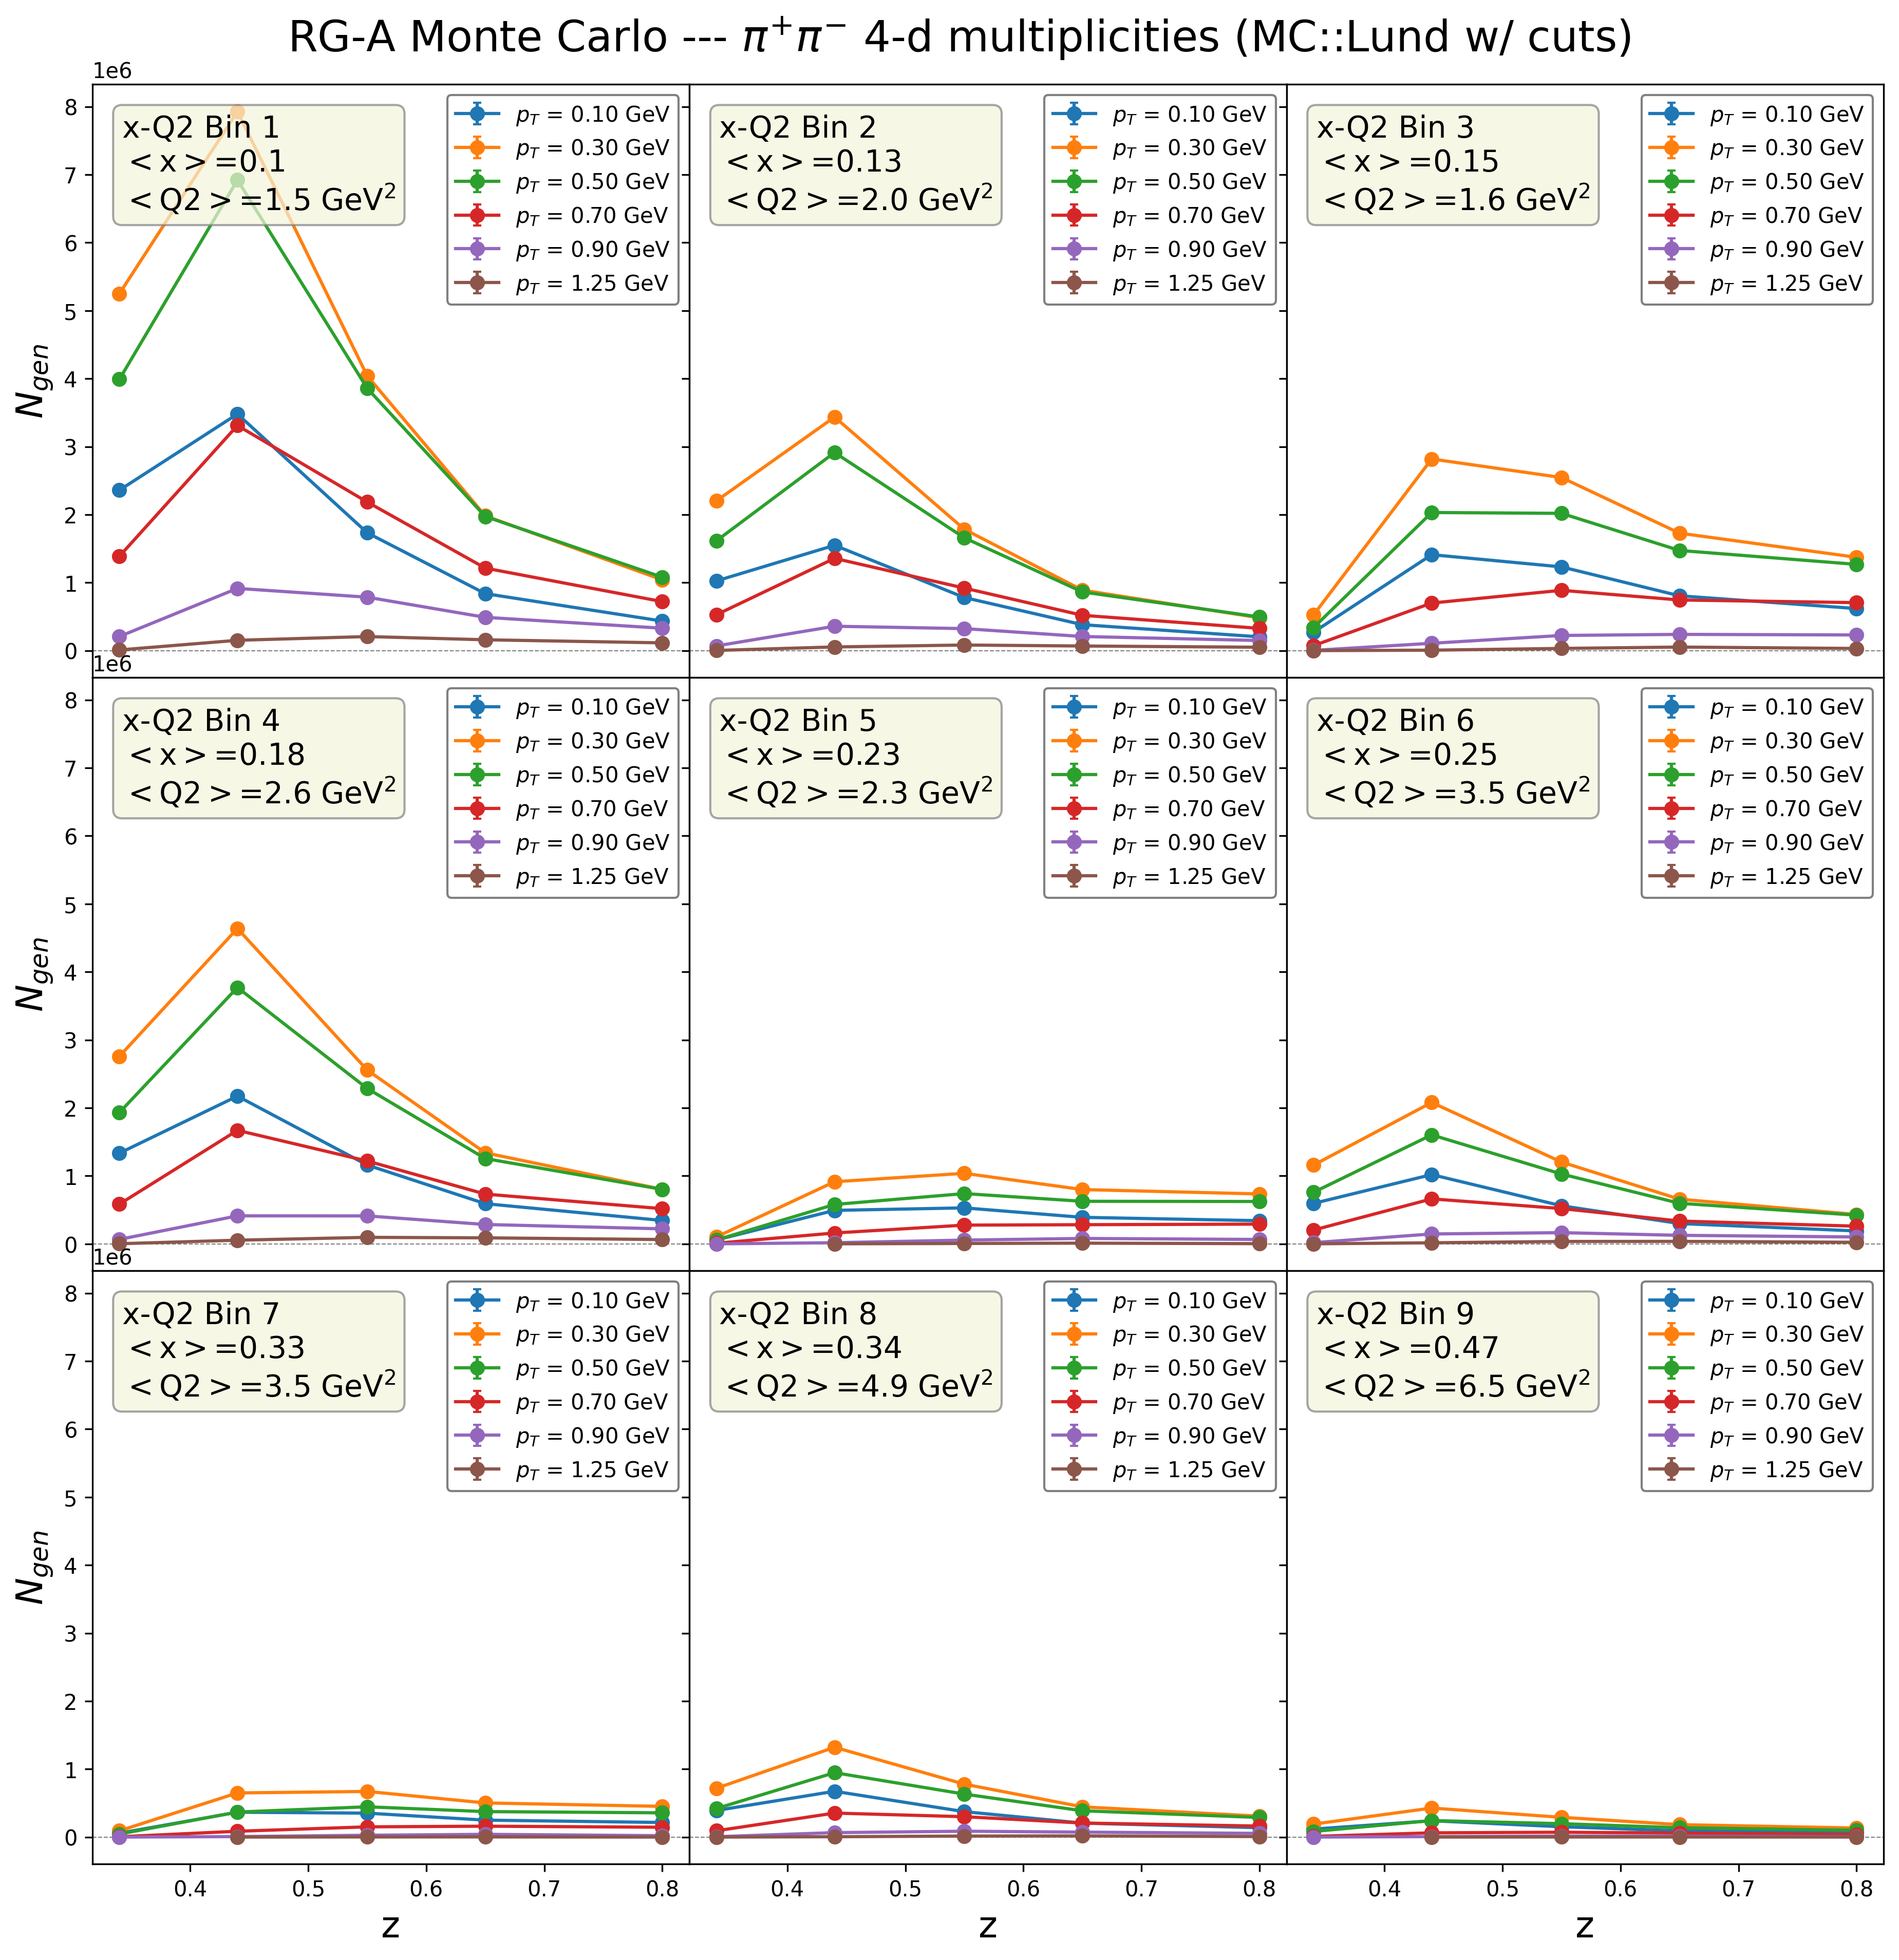

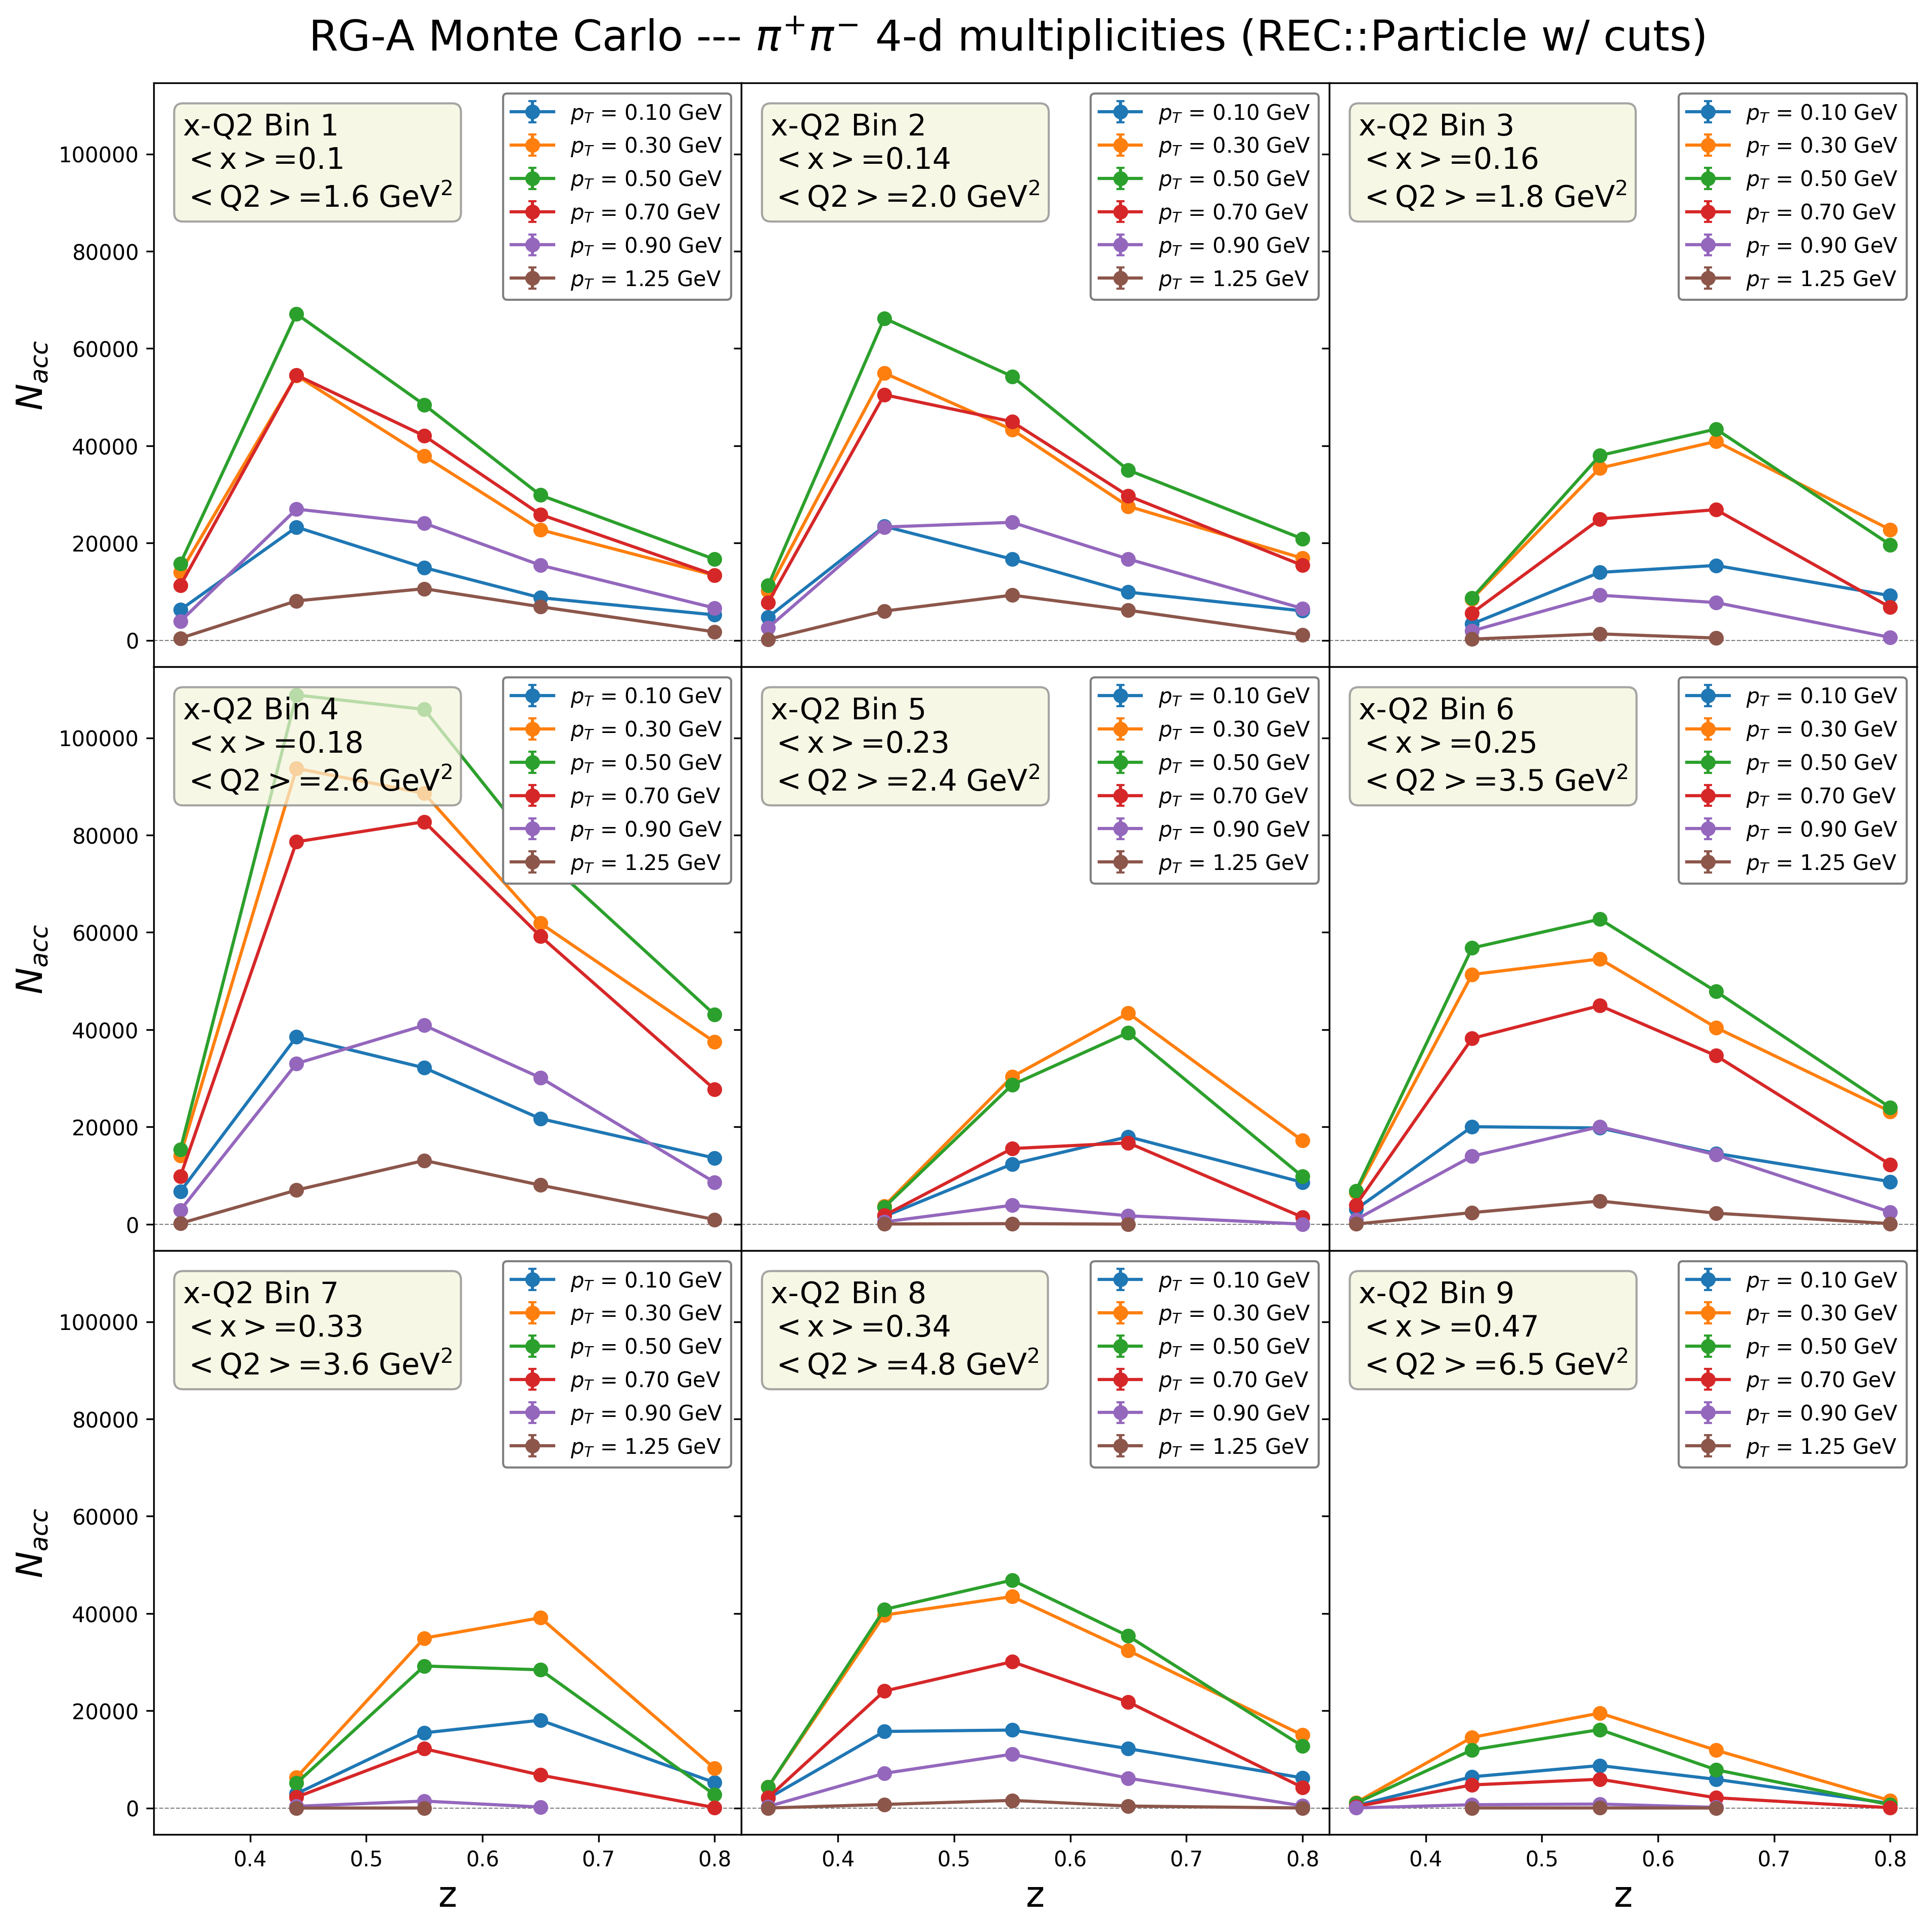

In [162]:
plot_data(mc_2h_yaml,  "z_grid",y_title="$N_{gen}$", title="RG-A Monte Carlo --- $\pi^{+}\pi^{-}$ 4-d multiplicities (MC::Lund w/ cuts)")
plot_data(exp_2h_yaml, "z_grid",y_title="$N_{acc}$",title="RG-A Monte Carlo --- $\pi^{+}\pi^{-}$ 4-d multiplicities (REC::Particle w/ cuts)")

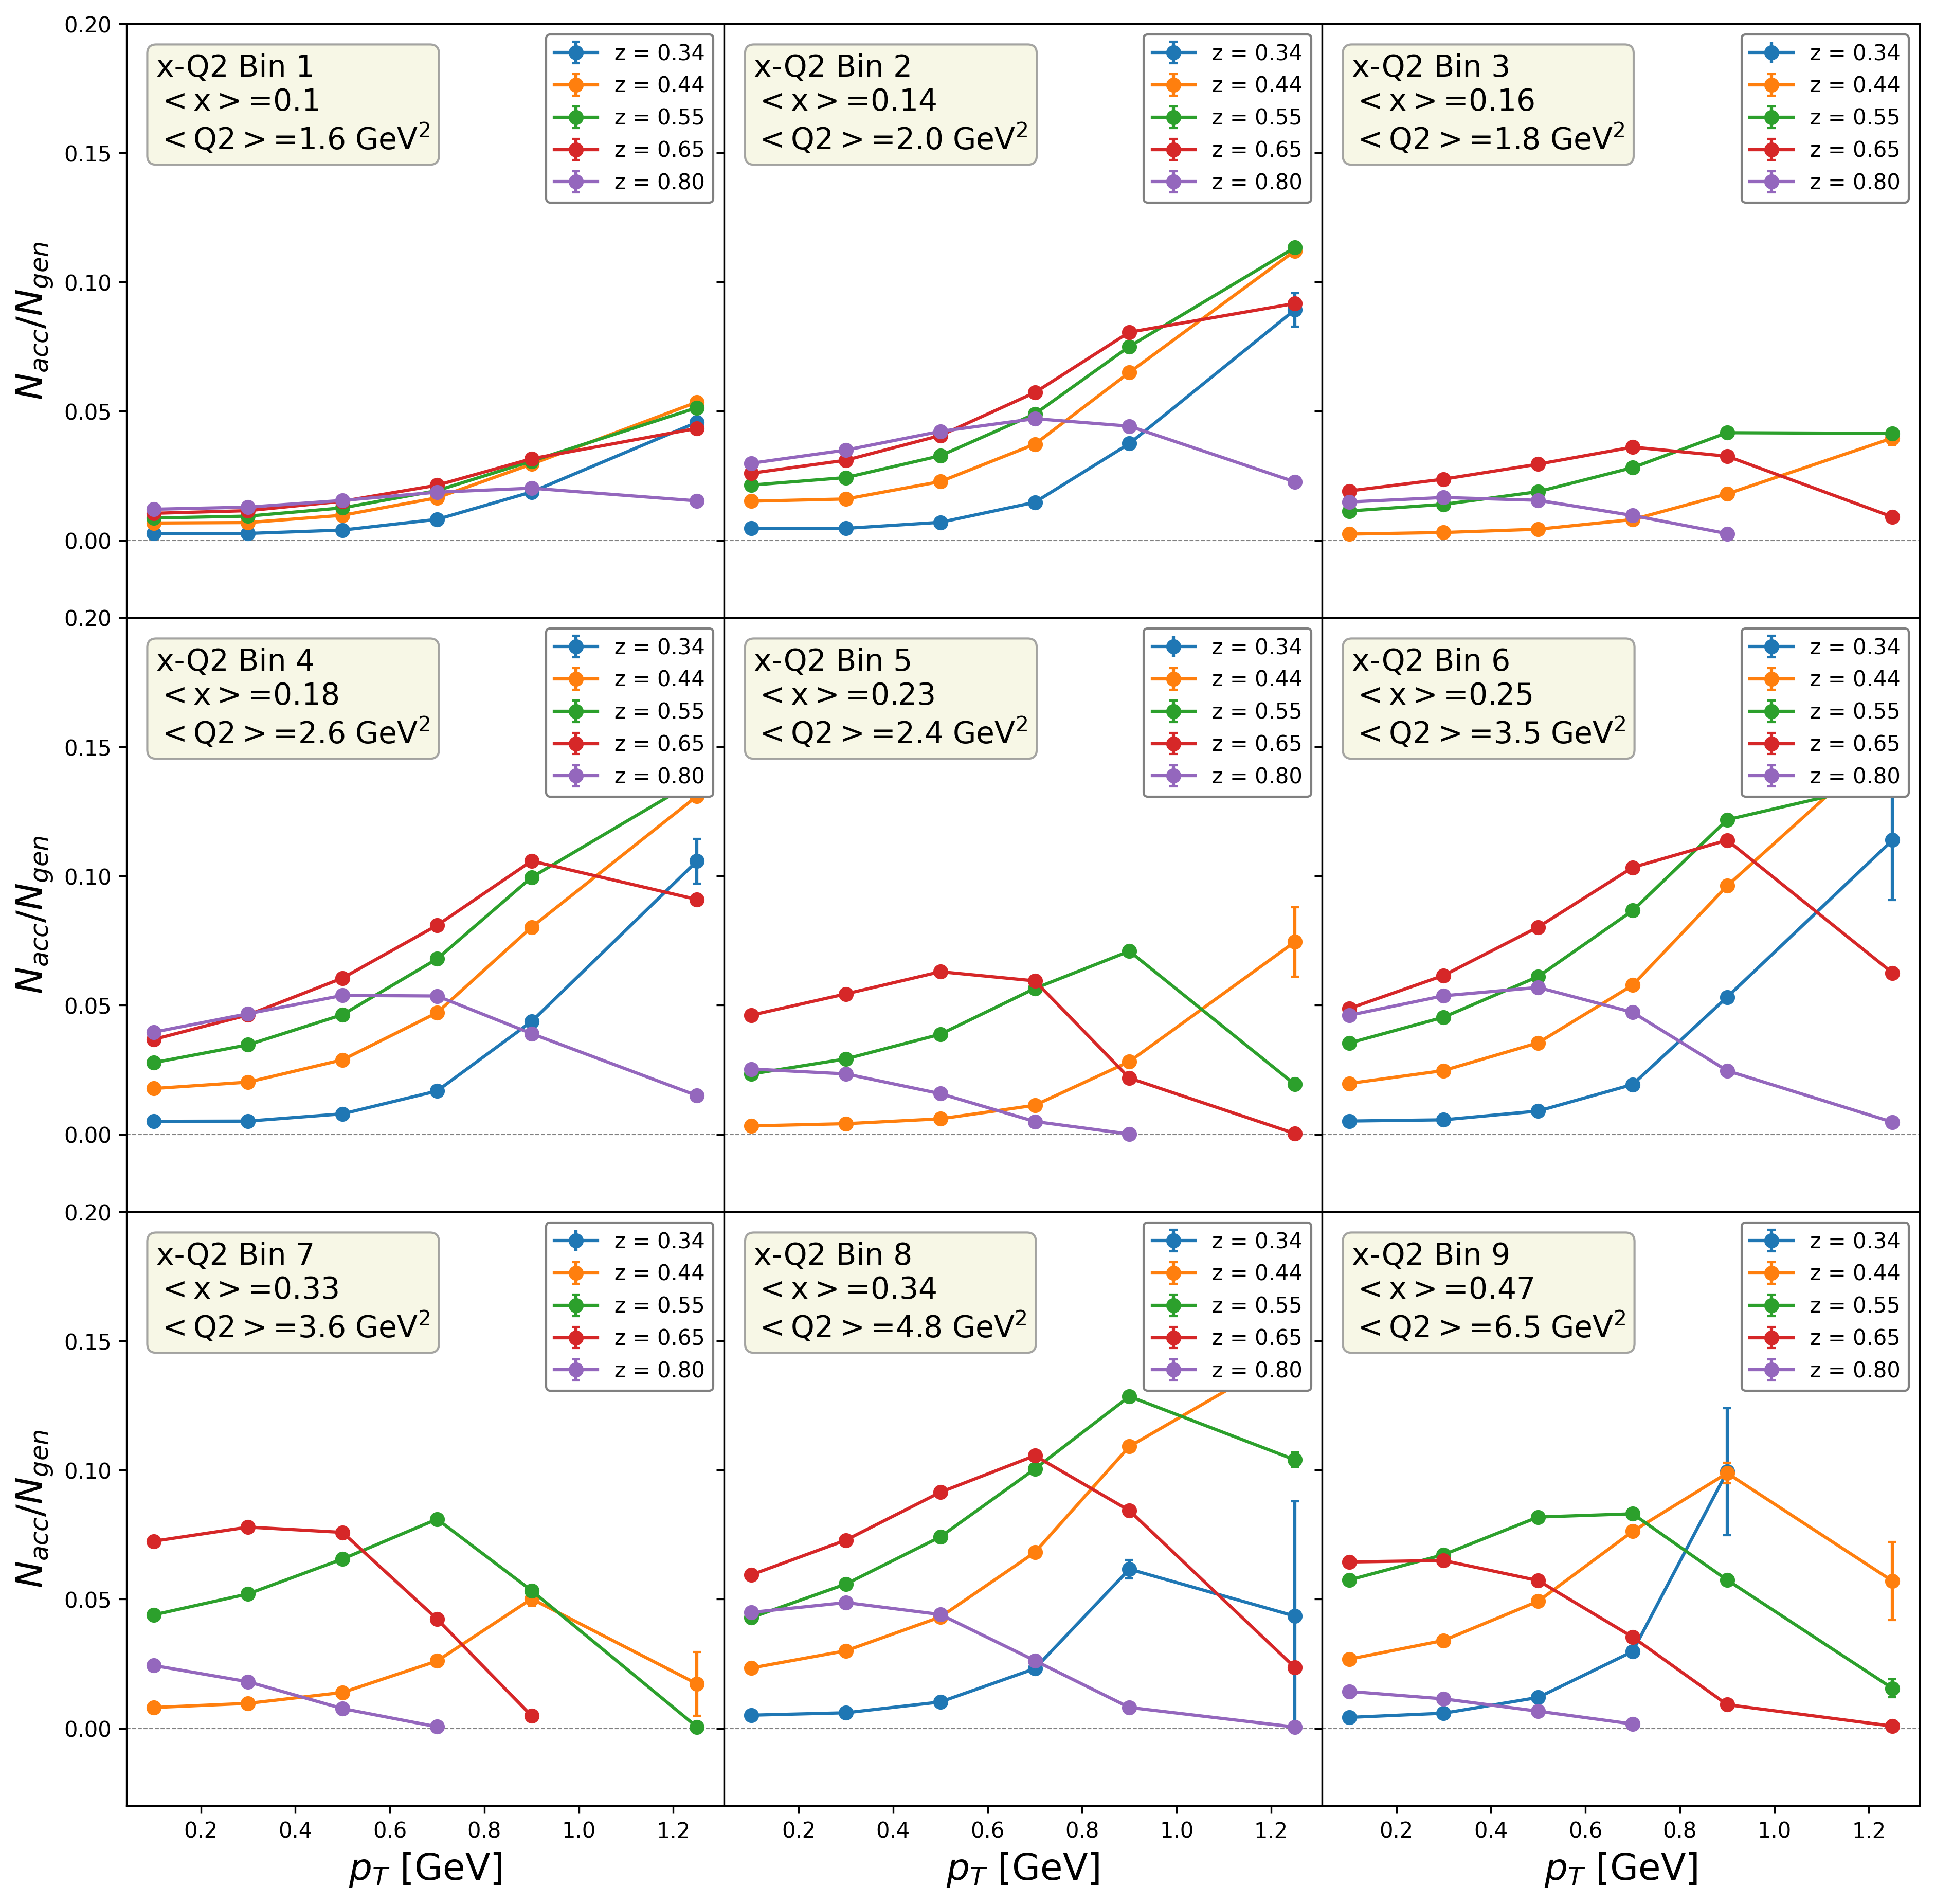

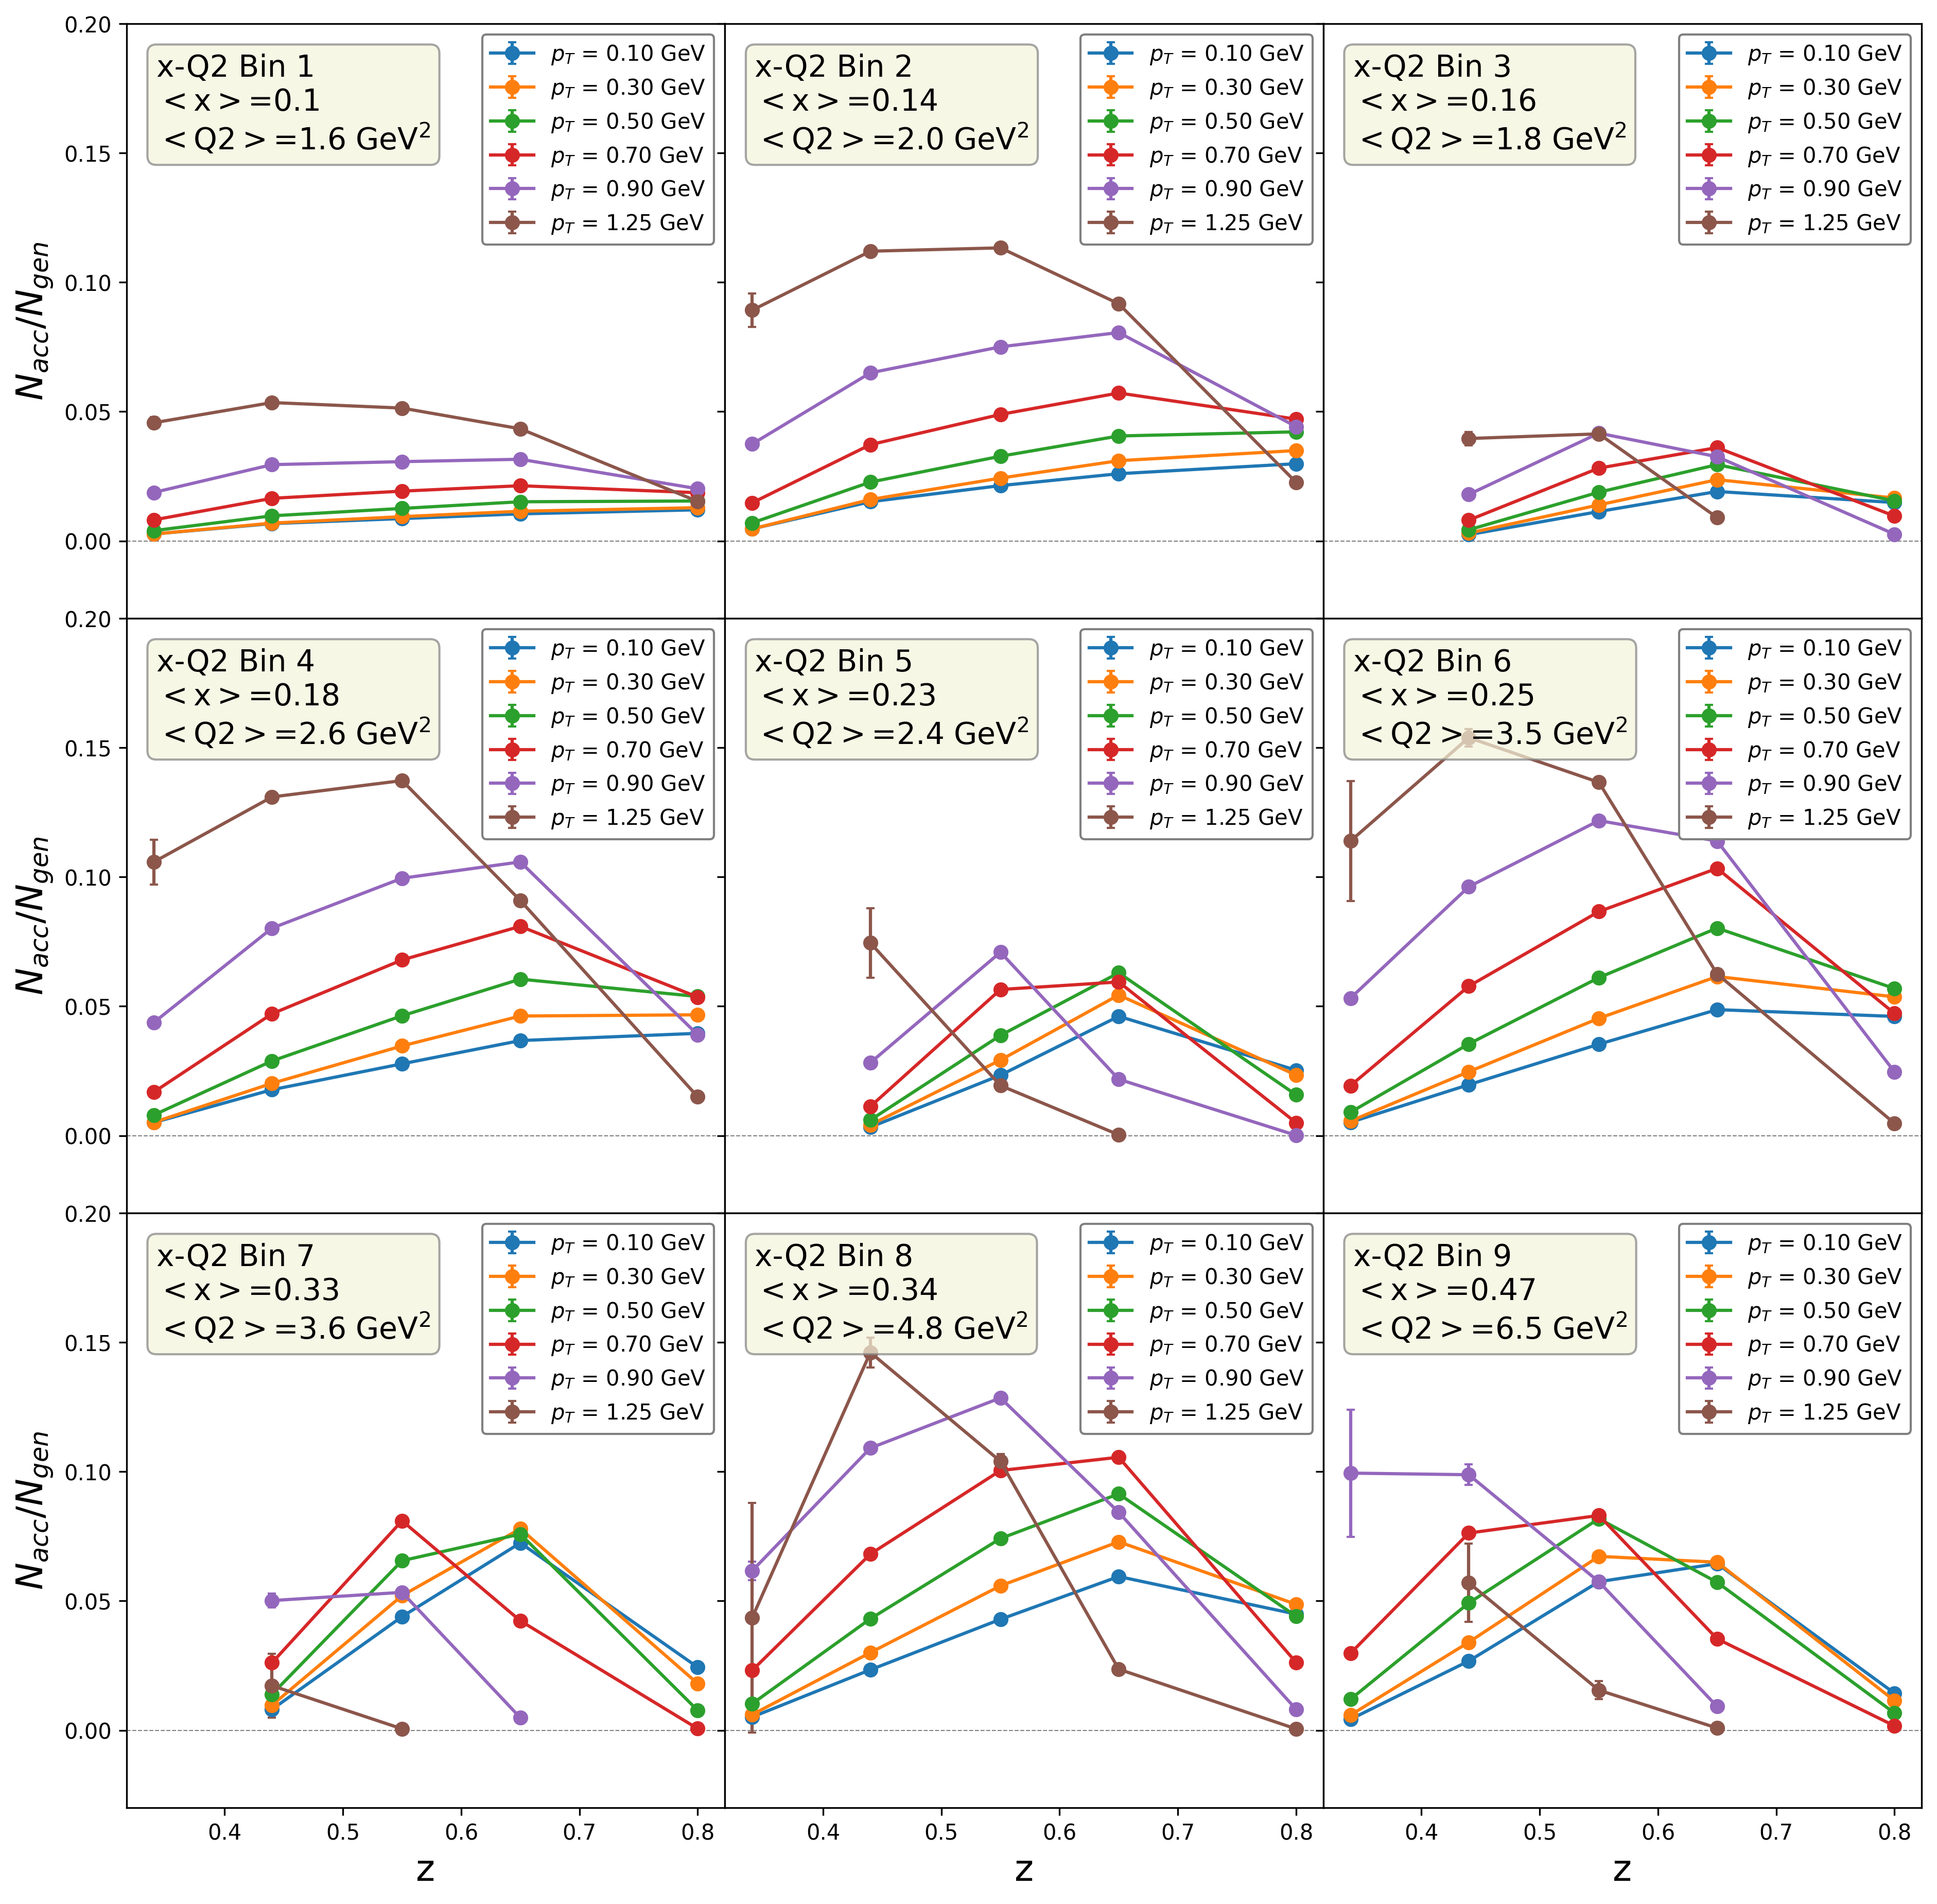

In [163]:
fraction=divide_counts(exp_2h_yaml,mc_2h_yaml)
plot_data(fraction, "pT_grid" ,y_title="$N_{acc}/N_{gen}$",y_lim=(-0.03,0.2))
plot_data(fraction, "z_grid" ,y_title="$N_{acc}/N_{gen}$",y_lim=(-0.03,0.2))